## **Name:** Alyssa Rask

## **Computing ID:** jez2sk

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# !pip install lime
from lime import lime_tabular
from sklearn.inspection import permutation_importance

# Below is a new package needed for this lab
# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# Lab 3: Decision Trees and Random Forests (100 Points)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/17jL6-gLQWYkZJZGzAduIlU4YET0u2Ek-?usp=sharing)

The goal of this lab is to optimize Decision Tree and Random Forest models using the provided dataset on census level data. Your goal is to build a Random Forest Classifier to be able to predict income levels above or below 50k.

The guidance this week is less prescriptive in terms of steps, so use the skills you have gained over the semester to build and evaluate your models. You will be graded on your model building, interpretation of the results and explanation of model selection. As always, you are welcome to rely on your classmates but submit your own code. Lastly, there are likely several correct approaches involving a variety of different conclusions, just make sure your conclusions are supported by your approach.


The dataset should be familiar as it's the census data, on 48,000+ individuals with a variety of variables and a target variable for above or below 50k in salary.

![](https://www.coopercenter.org/sites/default/files/styles/wide/public/wordpress_import/Figure1CesnsuBlog2-1024x512_0.png?itok=DwYqkfFm)

Look through the data dictionary at its source link: https://archive.ics.uci.edu/ml/datasets/Adult

# **Part 1: Data Preparation and EDA (15 points)**

In a text cell, answer the following exploratory questions and support your observations with any code, if needed.

## **Question 1 (2 points):**
## Read in the features (X) as a Pandas DataFrame. Show the first 5 rows of the features. How many rows do you have?



In [301]:
# Fetch dataset
adult = fetch_ucirepo(id=2)

In [302]:
X = adult.data.features
y = adult.data.targets

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [303]:
X.shape

(48842, 14)

**There is a total of...** 48842 rows

## **Question 2 (2 points):**
## Are there any potential issues in the data or target that need to be corrected? Why are they issues? What specific method would you use to correct them and why?

## Consider using code and reading the data description (https://archive.ics.uci.edu/dataset/2/adult) to explore:

*   Assumptions and ranges of collected data
*   Missing values (impute? drop?)
*   Numerical data types represented as strings
*   Encoding categorical data appropriately
*   Normalization
*   Standardization

## You will not need to consider feature imbalances or sampling in part 1 or 2 of the lab.

In [304]:
print(X.isnull().sum())

print((X == '?').sum()) 

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
dtype: int64


In [305]:
print(X.describe())

                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  


**Potential Issues:** Potential issues I've identified are... some missing values in workclass, occupation, and native-country, which show up as both NaNs and '?'. Since the number of missing entries isn’t that high, we could either drop the rows or impute the missing values. In this case, it might be easiest to just leave them in and let the encoder handle them during preprocessing, especially since the features and targets are separated.

There doesn’t appear to be any numeric data stored as strings, which is good. However, there are still many categorical columns that need to be encoded before training. We’ll also want to standardize the numerical features like age, capital-gain, and hours-per-week so that the model treats all features more evenly.

## **Question 3 (6 points):**
## Preprocess the data according to the issues and correction methods you've identified. Save the new features and target variable (if necessary) as X_clean and y_clean.

In [306]:
num_cols = X._get_numeric_data().columns
num_cols

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [307]:
cat_cols = list(set(X.columns)-set(num_cols))
cat_cols

['education',
 'relationship',
 'marital-status',
 'race',
 'workclass',
 'native-country',
 'sex',
 'occupation']

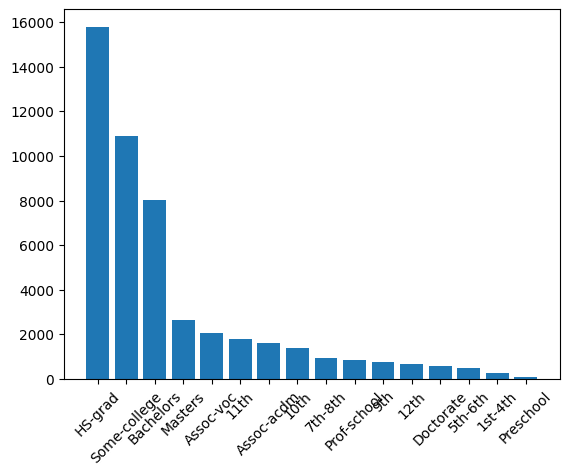

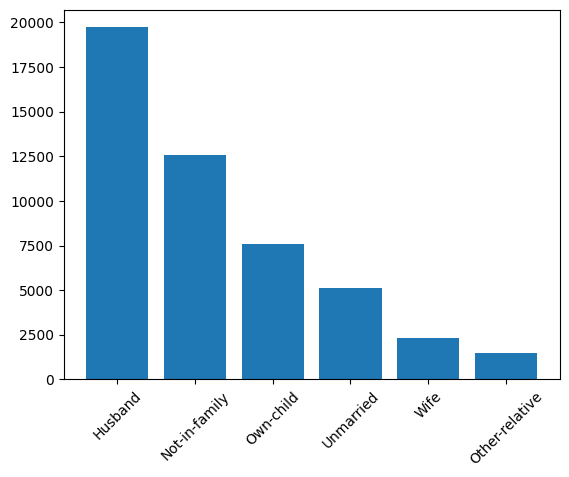

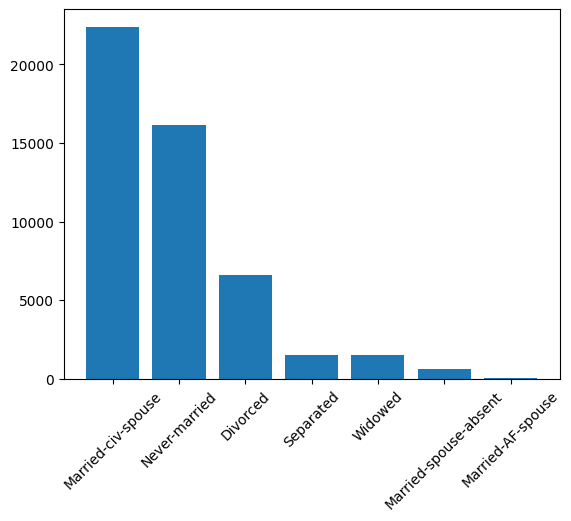

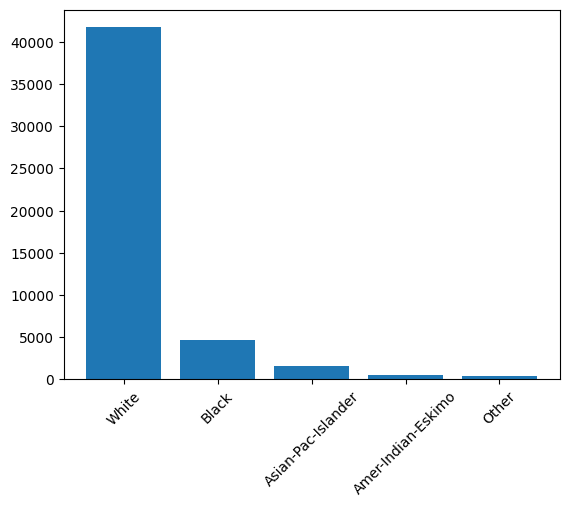

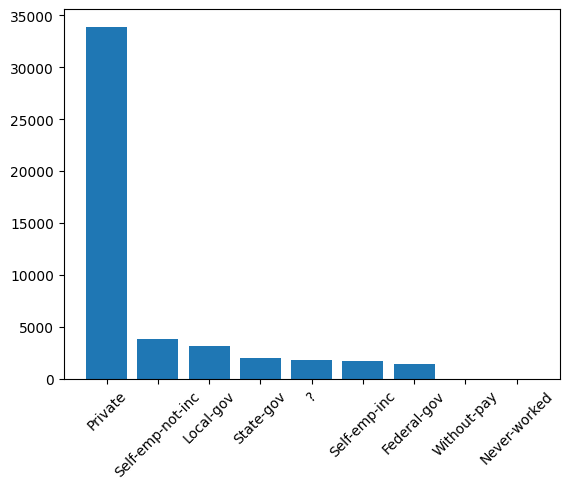

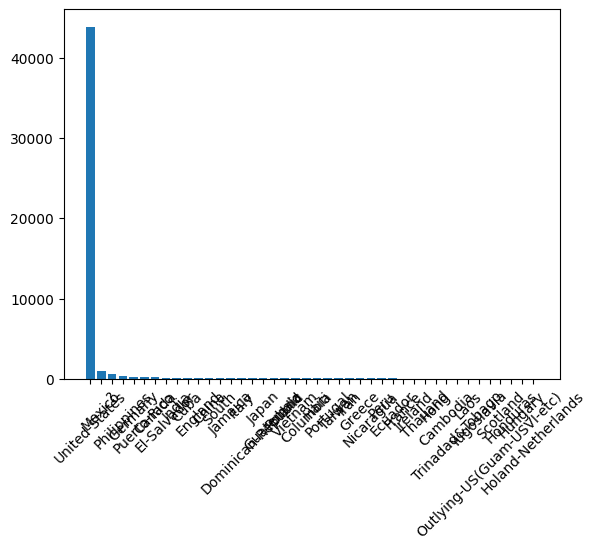

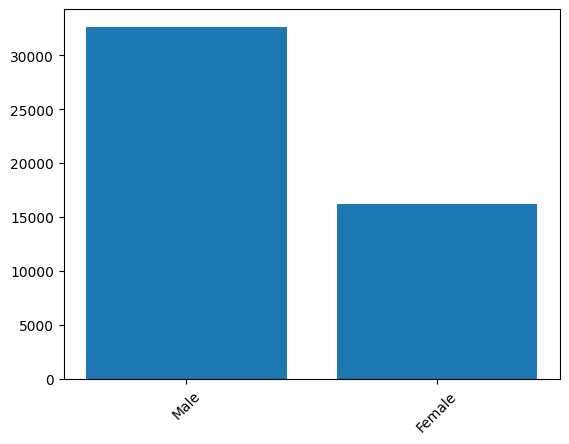

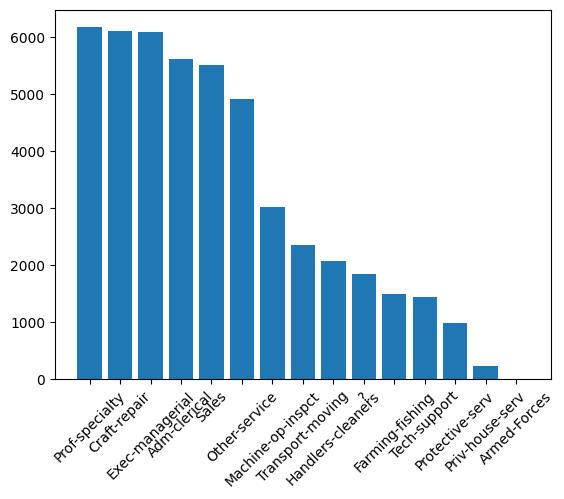

In [308]:
for col in cat_cols:
    i = X[col].value_counts().sort_values(ascending=False)
    plt.bar(i.index, i.values)
    plt.tick_params(axis='x', rotation=45)
    plt.show()

In [309]:
#check what percentage of the clumn is missing
nan_df = X.isnull().sum() * 100 / (X.count() + X.isnull().sum())
nan_df

age               0.000000
workclass         1.971664
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        1.977806
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.560993
dtype: float64

In [310]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

In [311]:
X.isnull().sum() * 100 / (X.count() + X.isnull().sum())

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
dtype: float64

In [312]:
X_clean = X.copy()

for col in num_cols:
    X_clean[col] = StandardScaler().fit_transform(X_clean[[col]])

# Check to make sure that the numerical columns are standardized
X_clean.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.025996,7,-1.061979,9,1.136512,4,1,1,4,1,0.146932,-0.217127,-0.034087,39
1,0.828308,6,-1.007104,9,1.136512,2,4,0,4,1,-0.144804,-0.217127,-2.213032,39
2,-0.046942,4,0.246034,11,-0.419335,0,6,1,4,1,-0.144804,-0.217127,-0.034087,39
3,1.047121,4,0.426663,1,-1.197259,2,6,0,2,1,-0.144804,-0.217127,-0.034087,39
4,-0.776316,4,1.408530,9,1.136512,2,10,5,2,0,-0.144804,-0.217127,-0.034087,5


In [313]:
y.value_counts().reset_index()

,income,count
0,<=50K,24720
1,<=50K.,12435
2,>50K,7841
3,>50K.,3846


In [314]:
#clean y
y_clean = y.copy()

y_clean.loc[y['income'].str.contains('<', regex=False), 'income'] = '<50k'
y_clean.loc[y['income'].str.contains('>', regex=False), 'income'] = '>50k'
y_clean.value_counts().reset_index()

,income,count
0,<50k,37155
1,>50k,11687


## **Question 4 (5 points):**
## Create 2 versions of y_clean to create a new target response of whether income is above or below $50,000 for classification.

1.   **y_clean_binary:** Recode y_clean to be 1 if the target is over or equal to
2.   **y_clean_string:** Recode y_clean to be "Above or Equal" if the target is over or equal to 50,000 and "Below" if under.



In [315]:
y_clean_binary = y_clean.copy()
y_clean_binary.loc[y_clean_binary['income'] == '<50k', 'income'] = 0
y_clean_binary.loc[y_clean_binary['income'] == '>50k', 'income'] = 1

y_clean_binary = y_clean_binary.astype(int)

y_clean_binary.value_counts().reset_index()

,income,count
0,0,37155
1,1,11687


In [316]:
y_clean_string = y_clean.copy()
y_clean_string.loc[y_clean_string['income'].str.contains('<', regex=False), 'income'] = 'Below'
y_clean_string.loc[y_clean_string['income'].str.contains('>', regex=False), 'income'] = 'Above or Equal'

y_clean_string.value_counts().reset_index()

,income,count
0,Below,37155
1,Above or Equal,11687


# **Part 2: Decision Tree Pruning, Tuning and Evaluation (30 Points)**

## **Question 1 (5 points):**
## Create a function to take in a feature variable (X) and (y). In this function, create a train test split with a random seed of 3001.

## Use a vanilla decision tree model to fit the model on the train set and predict on the test set. Print the precision, recall, and accuracy of the model after prediction.

## Test that your function runs on both y_clean_binary and y_clean_string. For any of the following questions, you may use whichever y_clean variable you'd like.


In [317]:
def train_decision_tree(X, y, criterion='gini', max_depth=None):
    
    y = y.squeeze() 

    # Convert y to numeric if it's in string format
    if isinstance(y.iloc[0], str):
        y = y.map({"Above or Equal": 1, "Below": 0}) 
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    return accuracy, precision, recall

In [318]:
train_decision_tree(X_clean, y_clean_string)

train_decision_tree(X_clean, y_clean_binary)

Accuracy: 0.8130821987920974
Precision: 0.6009913258983891
Recall: 0.6285097192224622
Accuracy: 0.8109325417135838
Precision: 0.5967741935483871
Recall: 0.6233261339092873


(0.8109325417135838, 0.5967741935483871, 0.6233261339092873)

## **Question 2 (5 points):**
## Adjust your function to include some plotting features. After your prediction code, plot:

1.   A visualization of the resulting decision tree
2.   A confusion matrix of the results

## Your tree might be overwhelming or very large! If it is too large to be interpreted, constrain the max_depth parameter manually to 5 or less.

In [319]:
def train_decision_tree(X, y, criterion='gini', max_depth=None):

    y = y.squeeze() 

    # Convert y to numeric if it's in string format
    if isinstance(y.iloc[0], str):
        y = y.map({"Above or Equal": 1, "Below": 0}) 
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)

    # Plot tree and a confusion matrix
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Below', 'Above or Equal'], max_depth=3, fontsize=10)
    plt.title('Decision Tree')
    plt.show()

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Below', 'Above or Equal']).plot()
    plt.show()
    
    return clf, accuracy, precision, recall

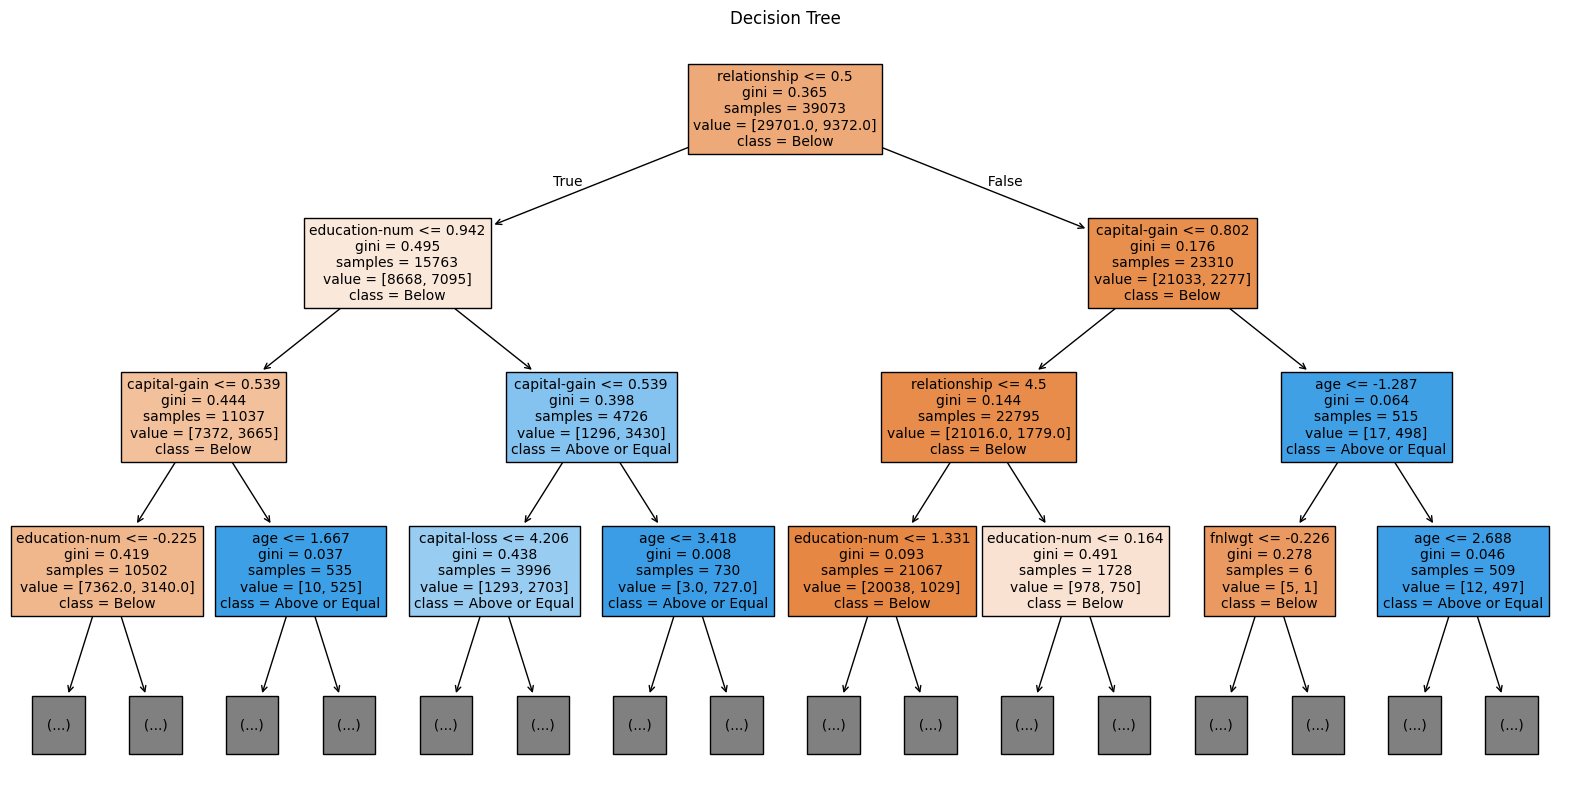

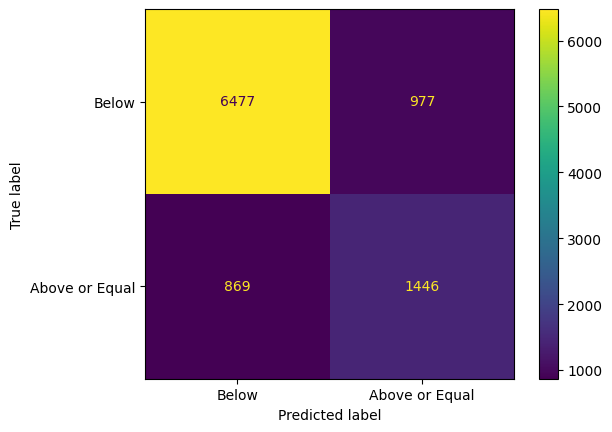

In [320]:
clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string)

## **Question 3 (5 points):**
## Create a sorted list of feature importances and comment on the top features.Are there a few that seem to be more important than the others?

## Plot your feature importances in a horizontal or vertical bar chart from most to least important. Label each bar with its feature importance rounded to the nearest integer (ie: 30%).

In [321]:
importances = clf.feature_importances_
indicies = np.argsort(importances)[::-1]
indicies

array([ 2,  7,  4,  0, 10, 12,  6, 11,  1, 13,  3,  8,  5,  9])

In [322]:
names = [X_clean.columns[i] for i in indicies]
names

['fnlwgt',
 'relationship',
 'education-num',
 'age',
 'capital-gain',
 'hours-per-week',
 'occupation',
 'capital-loss',
 'workclass',
 'native-country',
 'education',
 'race',
 'marital-status',
 'sex']

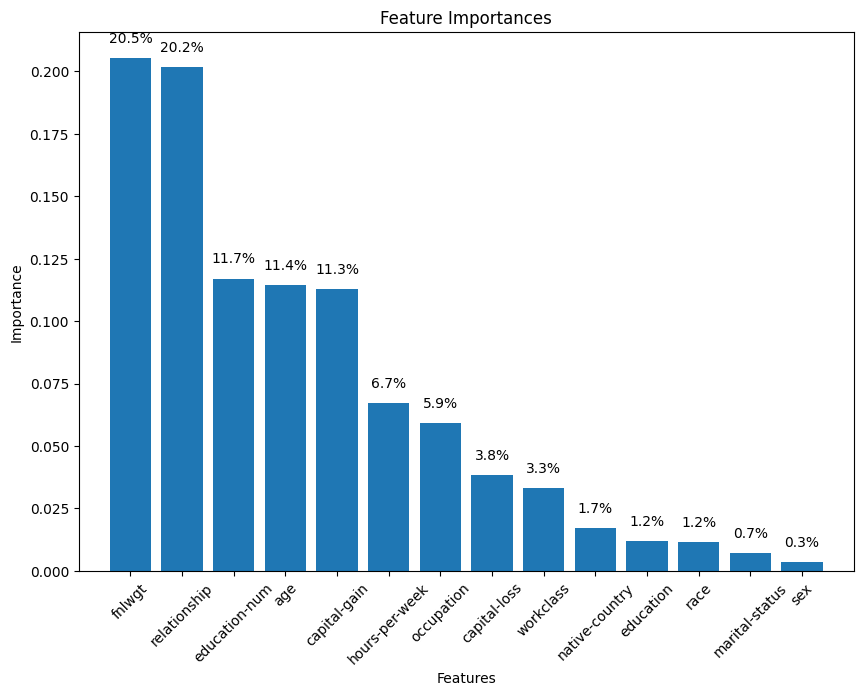

In [323]:
plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indicies], align='center')
plt.xticks(range(len(importances)), names, rotation=45)
plt.xlim([-1, len(importances)])
plt.xlabel('Features')
plt.ylabel('Importance')

for i, v, in enumerate(importances[indicies]):
    plt.text(i, v + 0.005, f'{round(v*100, 1)}%', ha='center', va='bottom')

## **Question 4 (5 points):**
## Write at least 5 sentences interpreting the results of your decision tree, confusion matrix, and feature importance visualizations.

## Is there any aspect of your results that you are uncertain or unsure of?

**My results show...** that "relationship" and "fnlwgt" were the most influential features in the model, followed by "education-num", "age", and "capital-gain". I was surprised that features like "education" and "marital-status" had relatively low importance, since I assumed they would be more relevant in predicting income, but I assume they are simply redundant to "relationship" and "education-num." The confusion matrix shows that the model performs fairly well overall, with most predictions falling along the diagonal, although there are more false positives than false negatives. 

In the decision tree, "relationship" is the first split, which matches its high importance, and the following splits include variables like "education-num" and "capital-gain", which also makes sense. One thing I found a bit confusing was that despite "fnlwgt" having high importance, I didn’t see it show up prominently in the tree—maybe it's used in deeper branches I couldn’t view. This makes me wonder if the feature importance values are coming from averaging over many trees or just one.

## **Question 5 (5 points):**
## Finally, we will create a new function to tune your decision tree to get more accurate and efficient results. Update your function to take in several new parameters with these default values:
* criterion_val ='gini'
* splitter_val ='best'
* max_depth_val = None
* min_samples_split_val = 2
* min_samples_leaf_val =1

## Pass your own variable into the decision tree by specifying what sklearn parameter you are trying to tune. This will simply be the parameter without the "_val" suffix.

## **For example, if your vanilla decision tree variable is called clf, you would adjust it like this:**
`clf = DecisionTreeClassifier(criterion=criterion_val, splitter=splitter_val, ...)`

In [324]:
def train_decision_tree(X, y, criterion = 'gini', splitter ='best', max_depth = None,
                            min_samples_split = 2, min_samples_leaf = 1):

    y = y.squeeze() 

    # Convert y to numeric if it's in string format
    if isinstance(y.iloc[0], str):
        y = y.map({"Above or Equal": 1, "Below": 0}) 
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)

    # Plot tree and a confusion matrix
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Below', 'Above or Equal'], max_depth=3, fontsize=10)
    plt.title('Decision Tree')
    plt.show()

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Below', 'Above or Equal']).plot()
    
    # Adding in the ability to get the feature importances and plot them
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    names = [X_clean.columns[i] for i in indices]
    
    plt.figure(figsize=(10, 7))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indicies], align='center')
    plt.xticks(range(len(importances)), names, rotation=45)
    plt.xlim([-1, len(importances)])
    plt.xlabel('Features')
    plt.ylabel('Importance')

    for i, v, in enumerate(importances[indicies]):
        plt.text(i, v + 0.005, f'{round(v*100, 1)}%', ha='center', va='bottom')

    plt.show()

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    return clf, accuracy, precision, recall

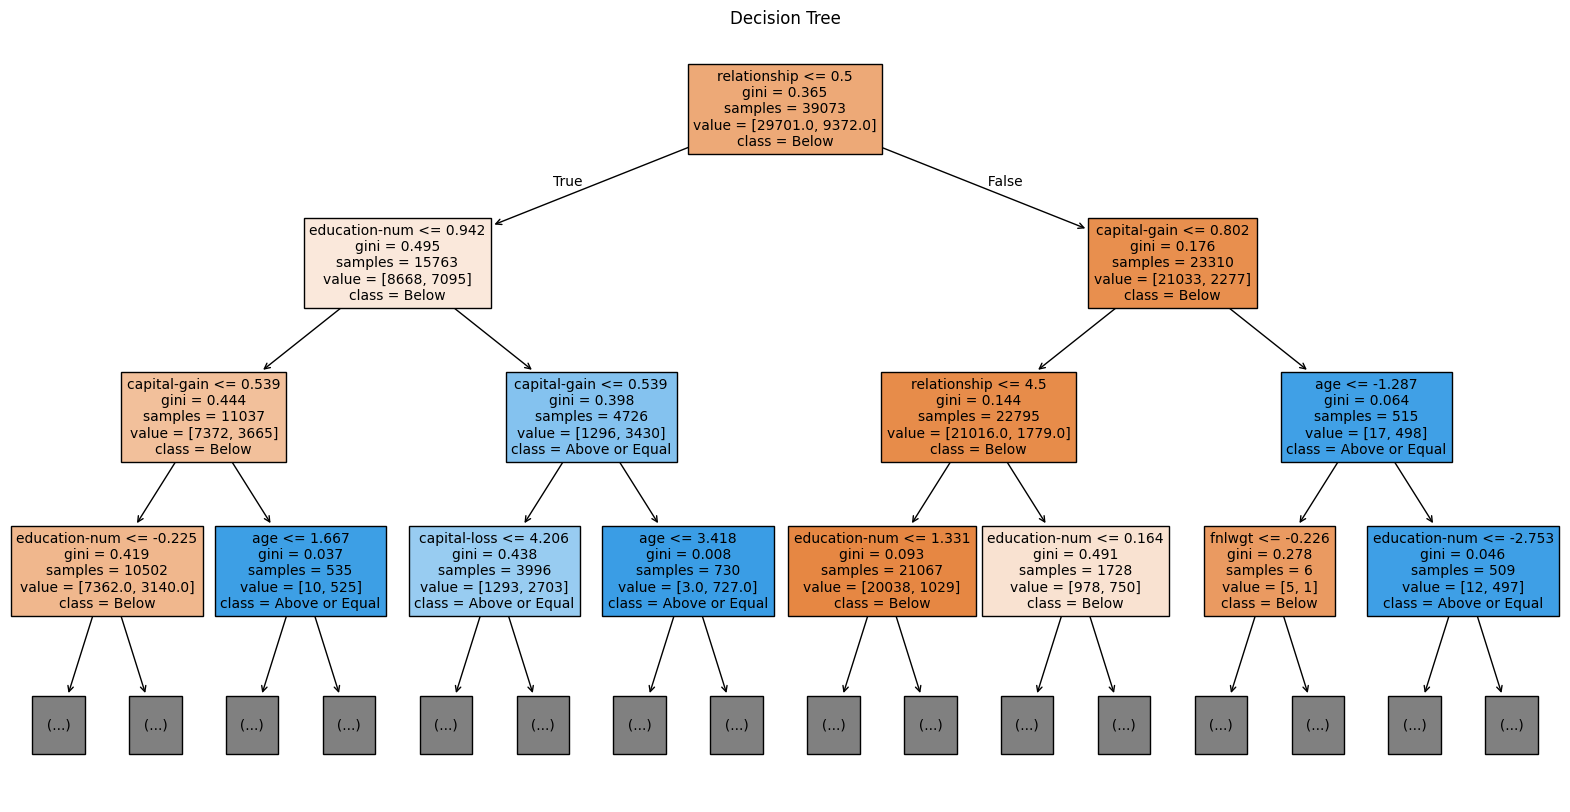

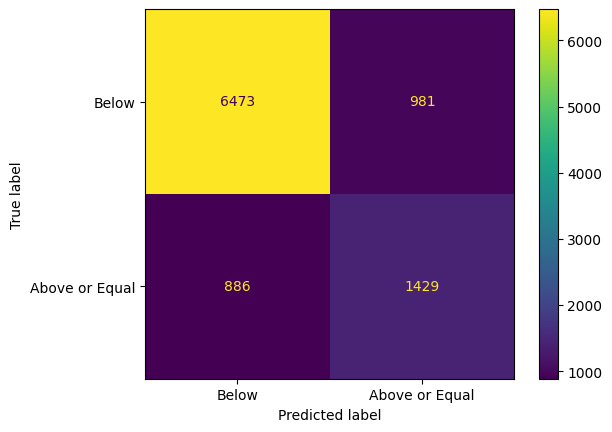

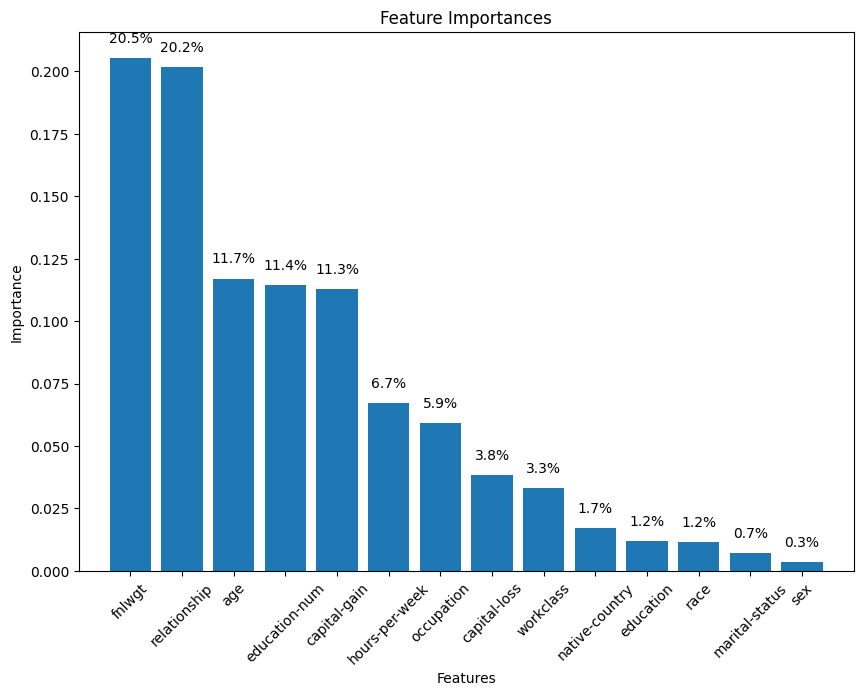

Accuracy: 0.81
Precision: 0.59
Recall: 0.62


In [325]:
clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string)

## **Question 6 (5 points):**

## Call your new function with either clean y variable at least 3 times. Each time, vary the values for all the parameters and examine its effects on your tree, confusion matrix, and metrics.

## You will likely want to look at documentation to see accepted values:  
###https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Why did you pick the values you did? What combination had the best effect on accuracy? Were you surprised by any of the results?

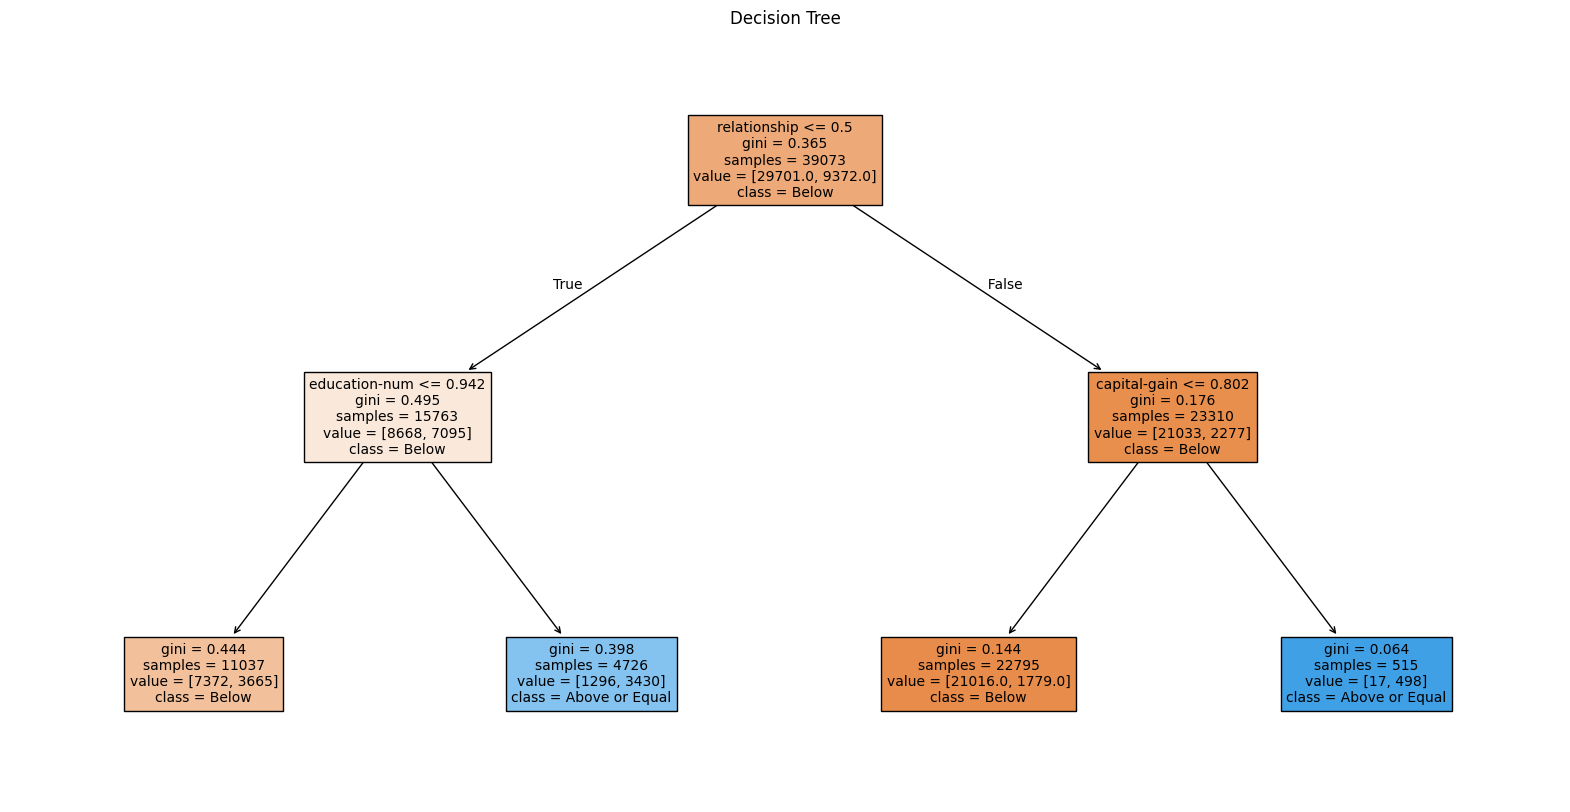

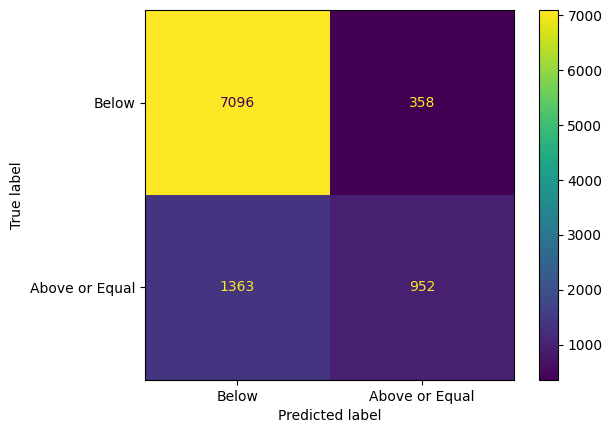

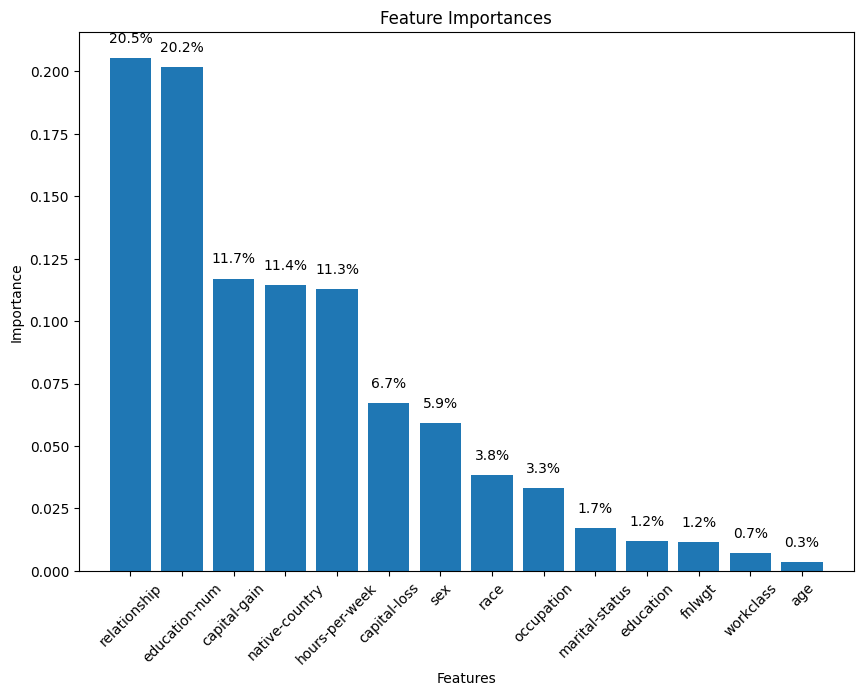

Accuracy: 0.82
Precision: 0.73
Recall: 0.41


In [326]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 2,
                                                      min_samples_split = 2,
                                                      min_samples_leaf = 2)

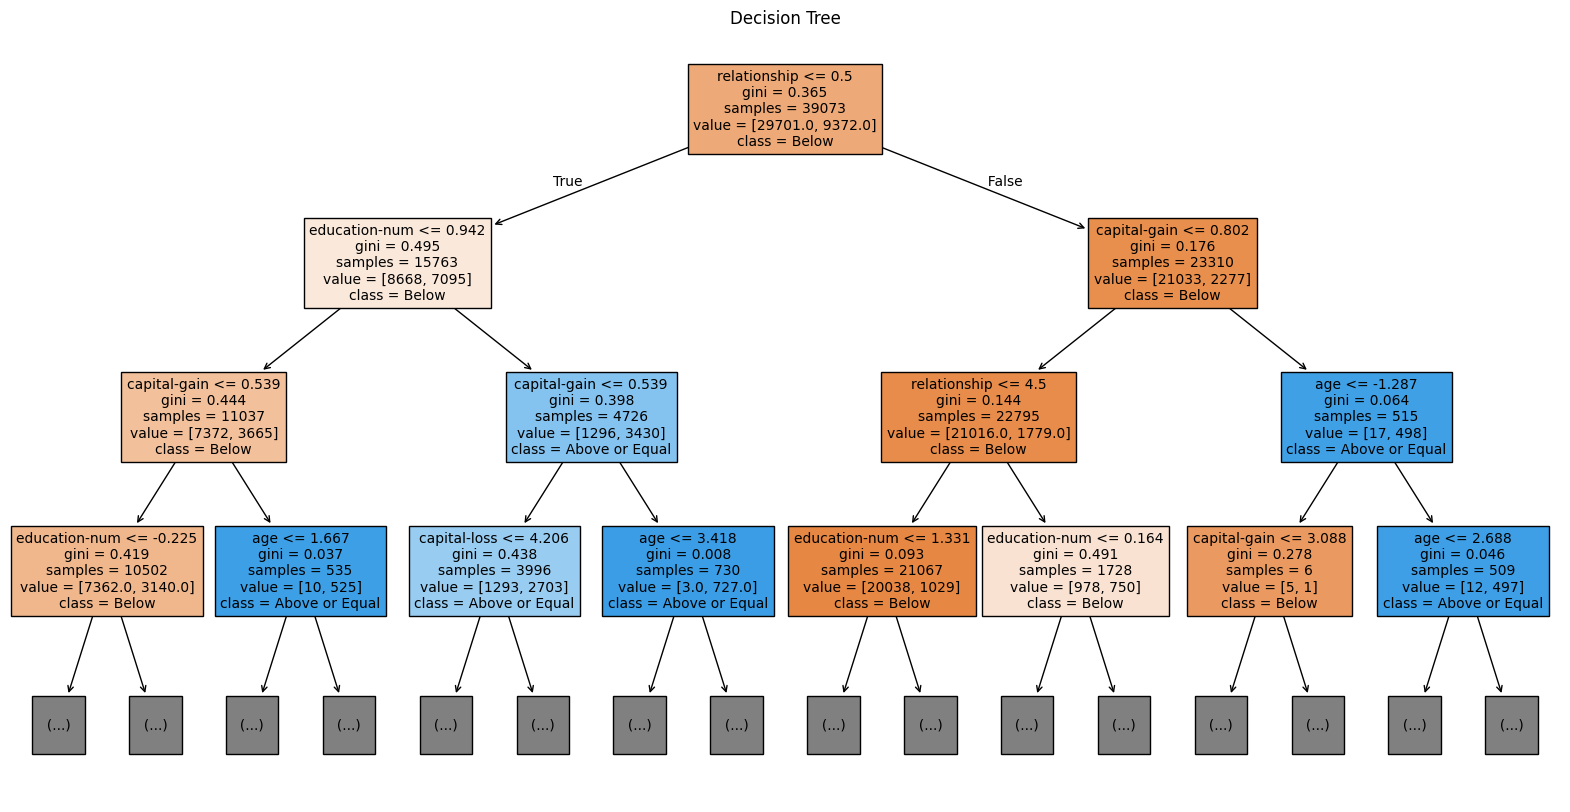

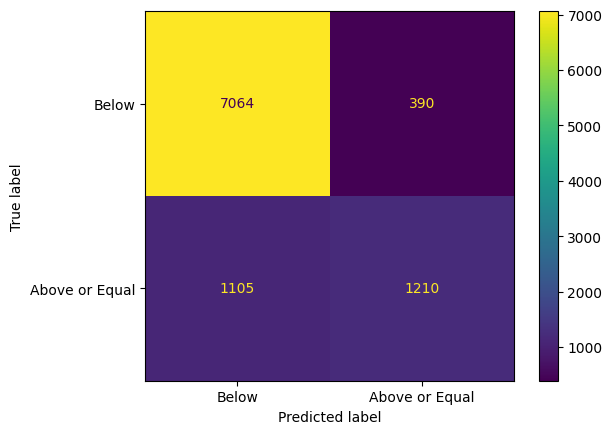

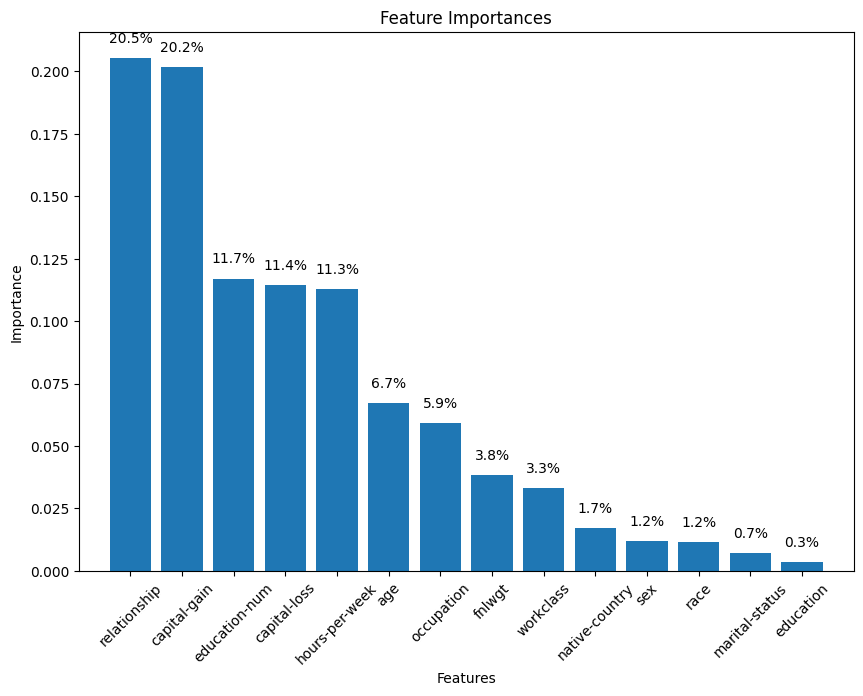

Accuracy: 0.85
Precision: 0.76
Recall: 0.52


In [327]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 5,
                                                      min_samples_split = 5,
                                                      min_samples_leaf = 5)

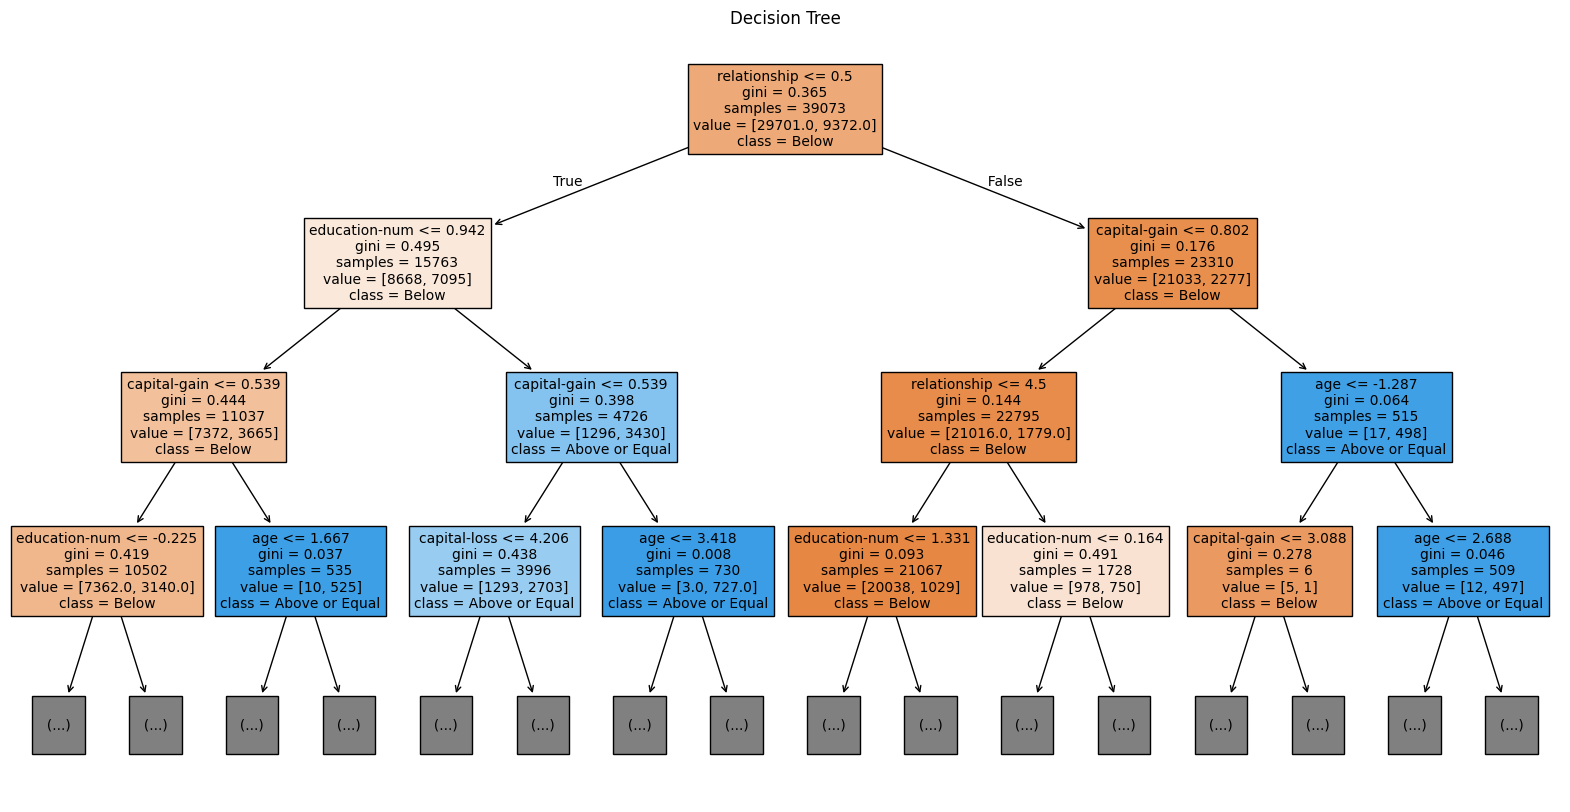

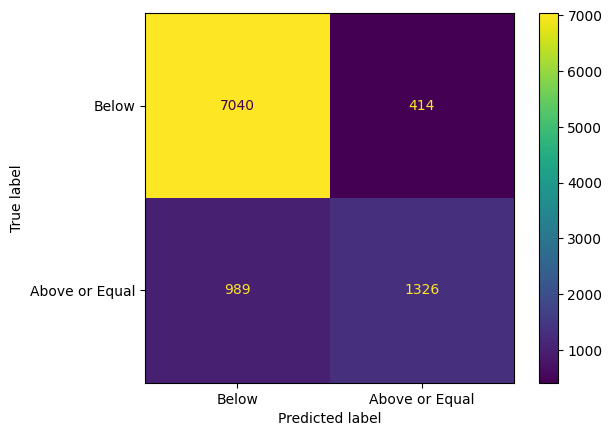

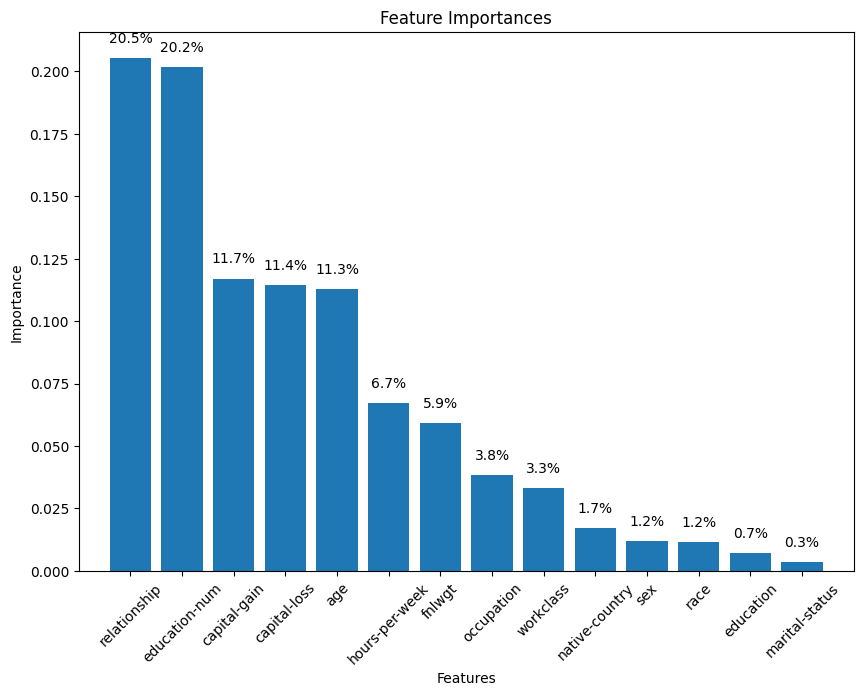

Accuracy: 0.86
Precision: 0.76
Recall: 0.57


In [328]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 10,
                                                      min_samples_split = 5,
                                                      min_samples_leaf = 5)

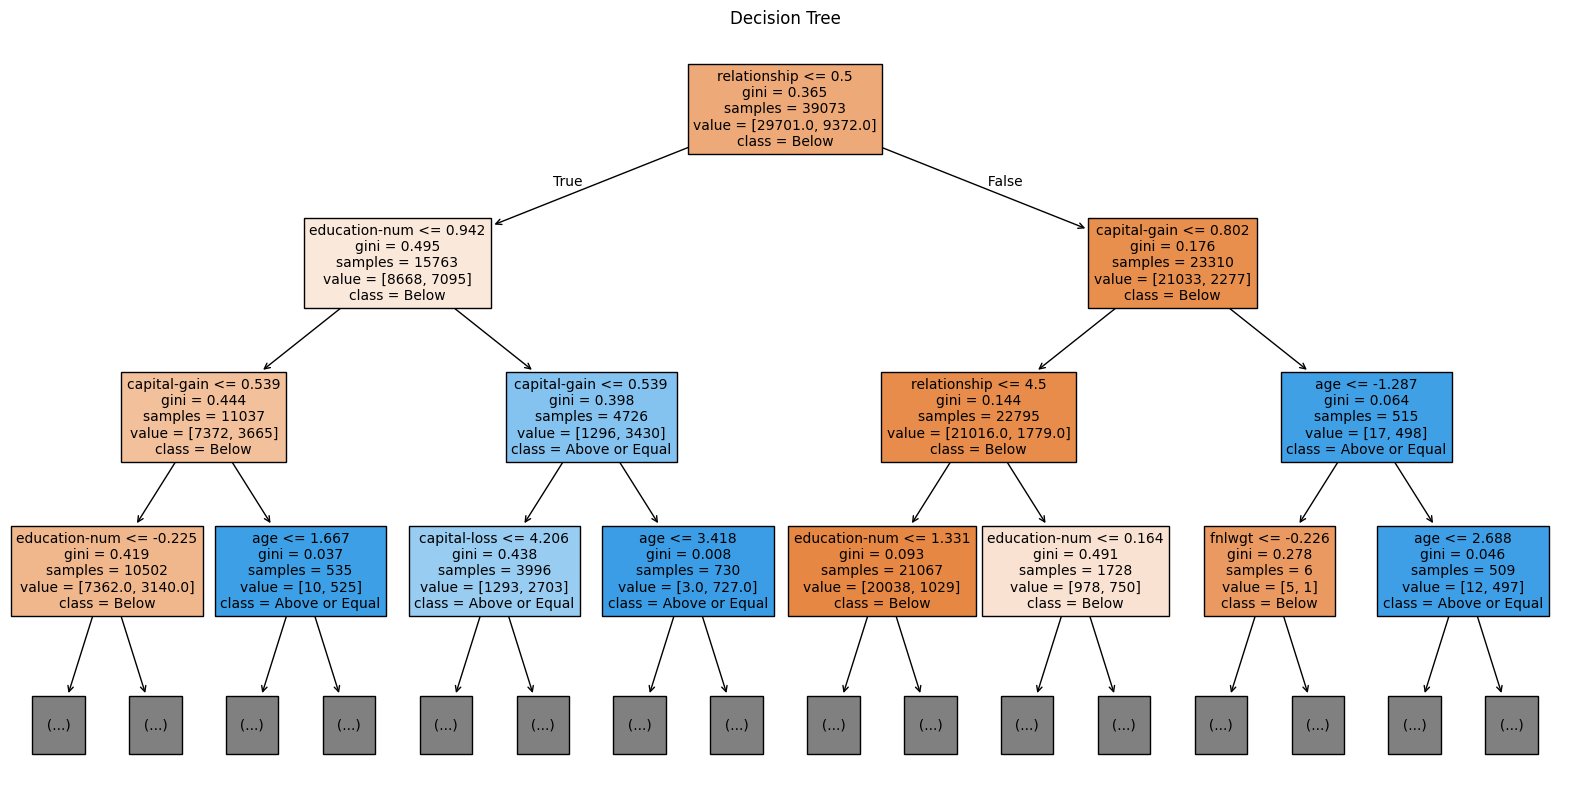

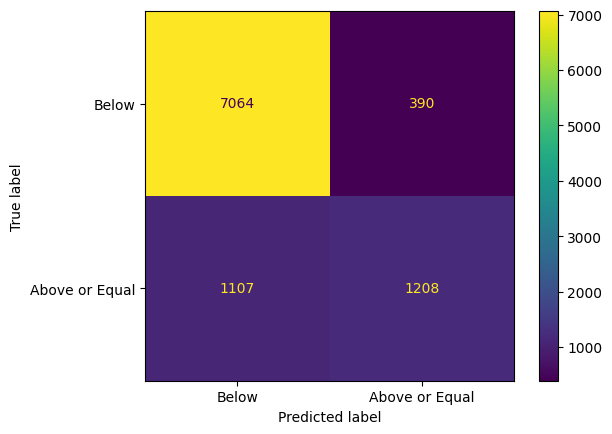

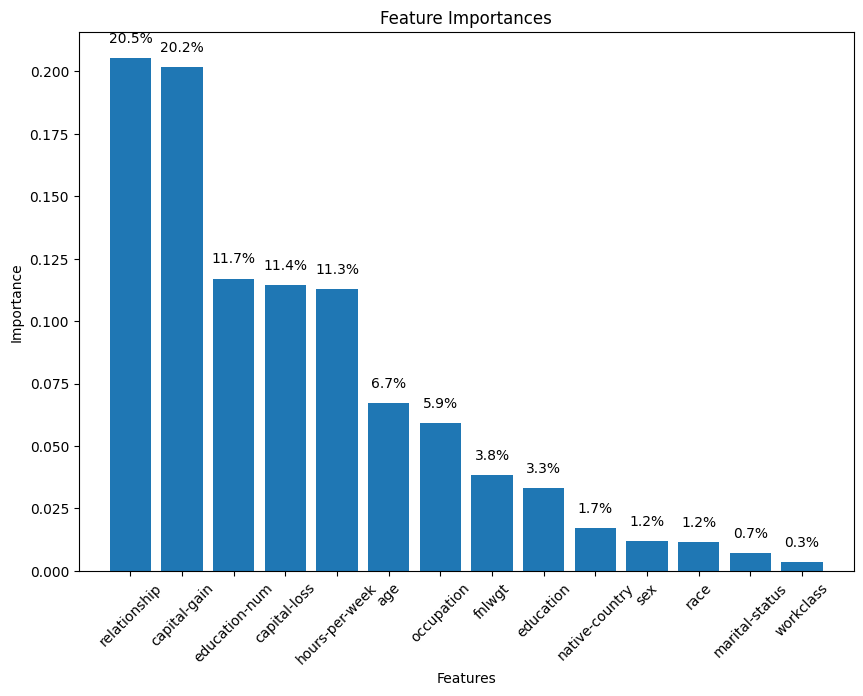

Accuracy: 0.85
Precision: 0.76
Recall: 0.52


In [329]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 5,
                                                      min_samples_split = 10,
                                                      min_samples_leaf = 5)

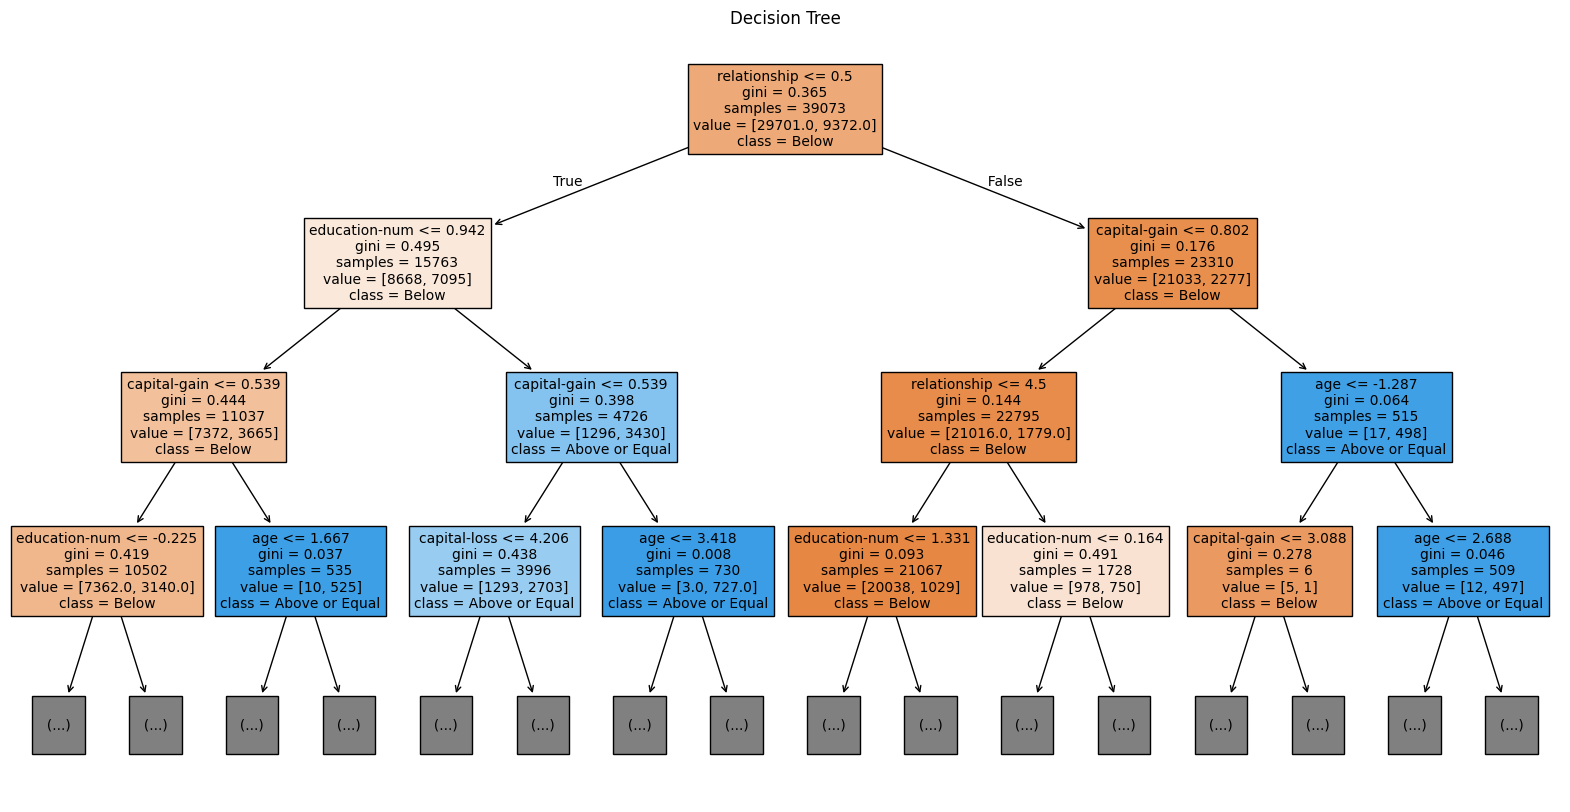

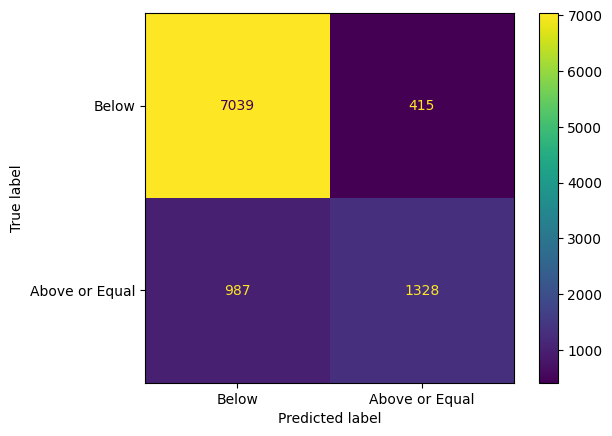

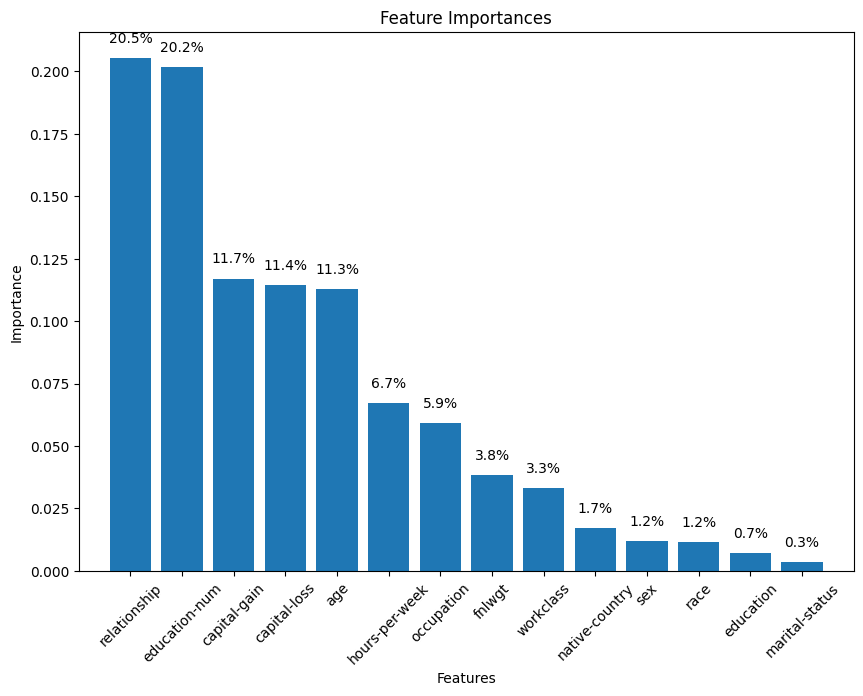

Accuracy: 0.86
Precision: 0.76
Recall: 0.57


In [330]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 10,
                                                      min_samples_split = 10,
                                                      min_samples_leaf = 10)

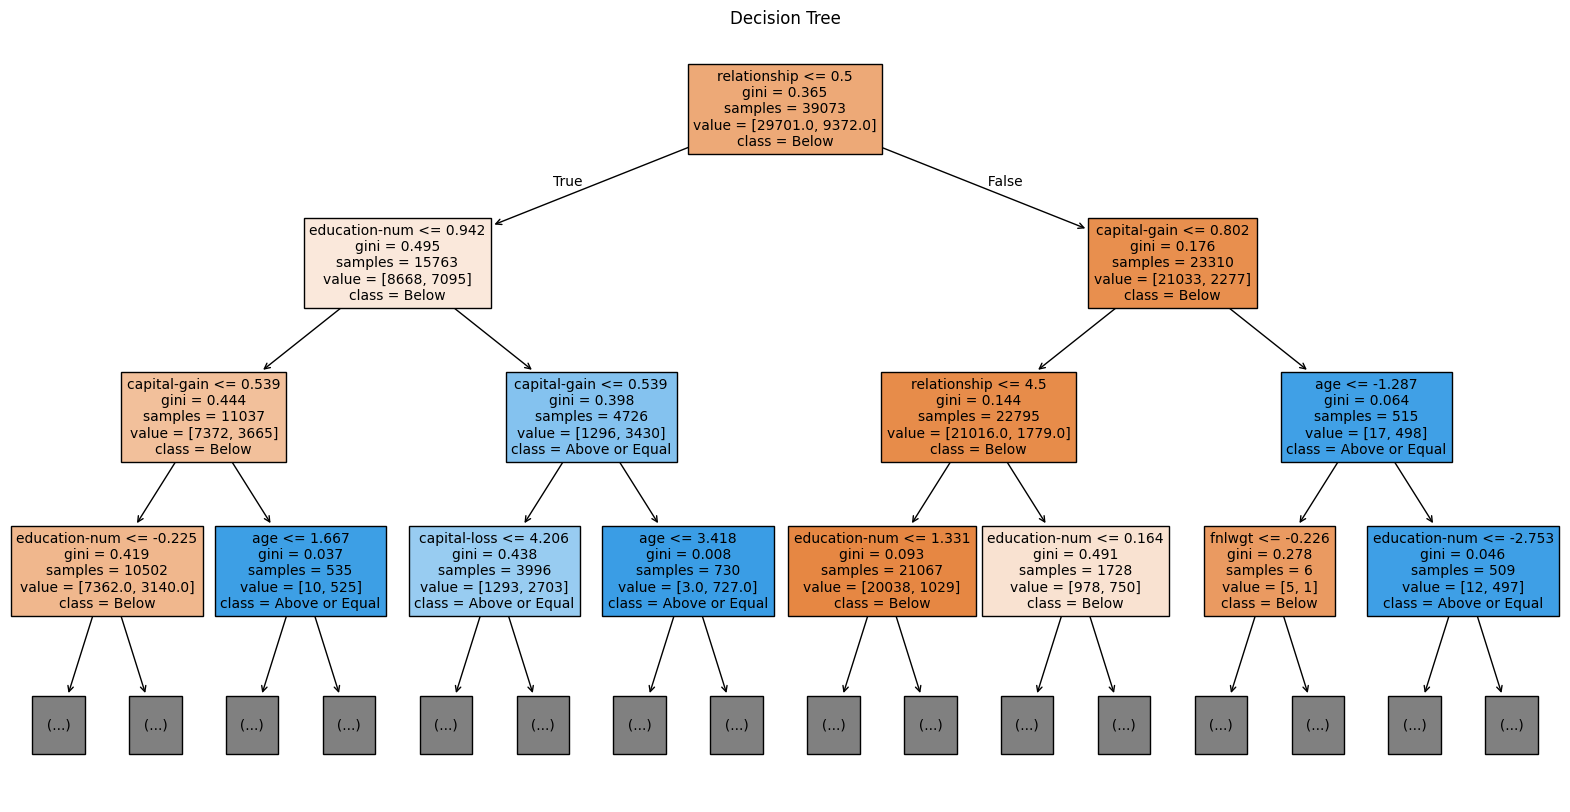

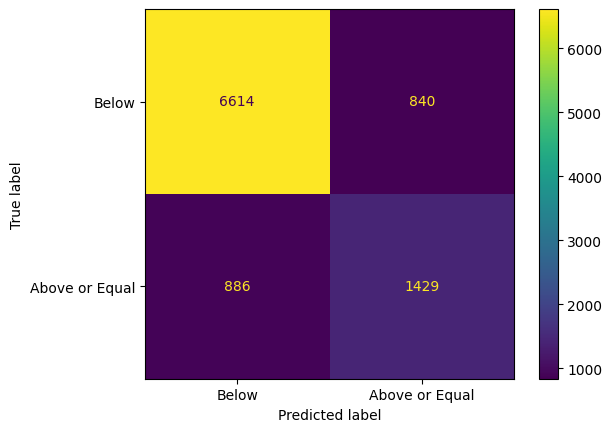

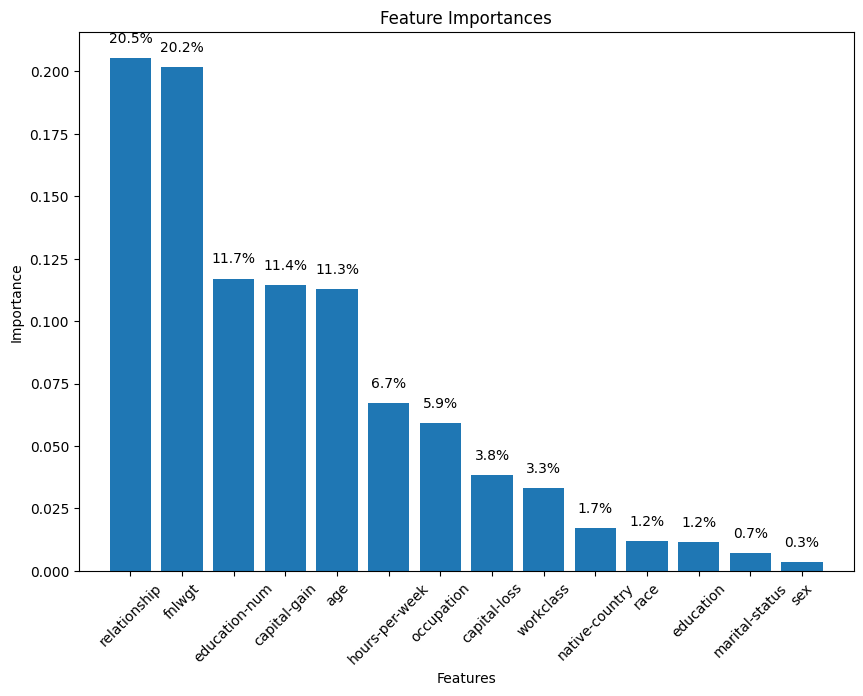

Accuracy: 0.82
Precision: 0.63
Recall: 0.62


In [331]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 20,
                                                      min_samples_split = 10,
                                                      min_samples_leaf = 10)

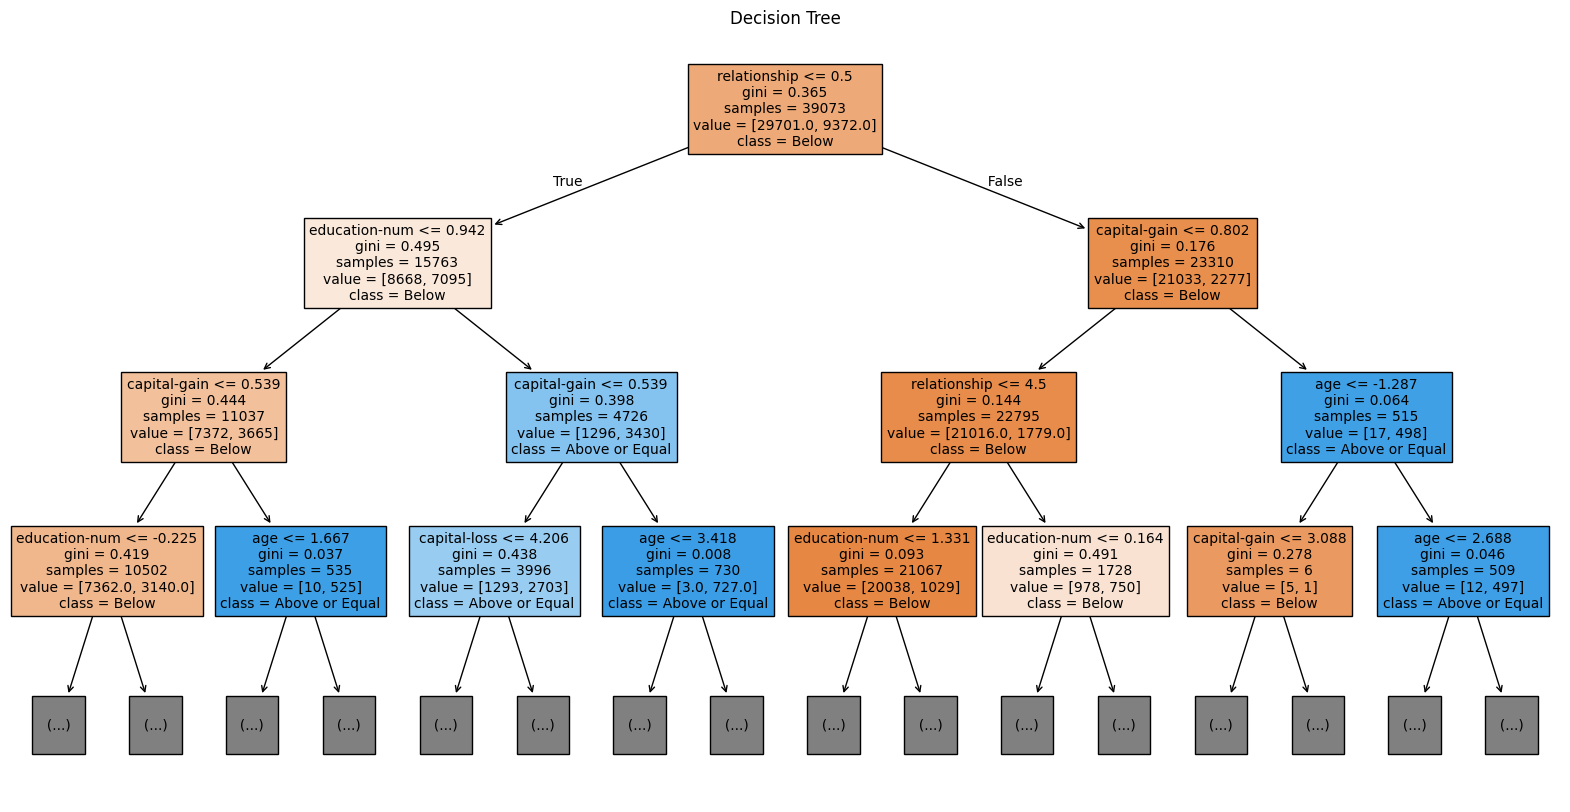

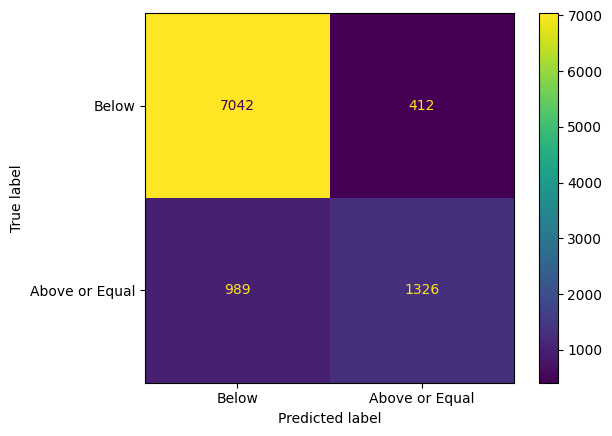

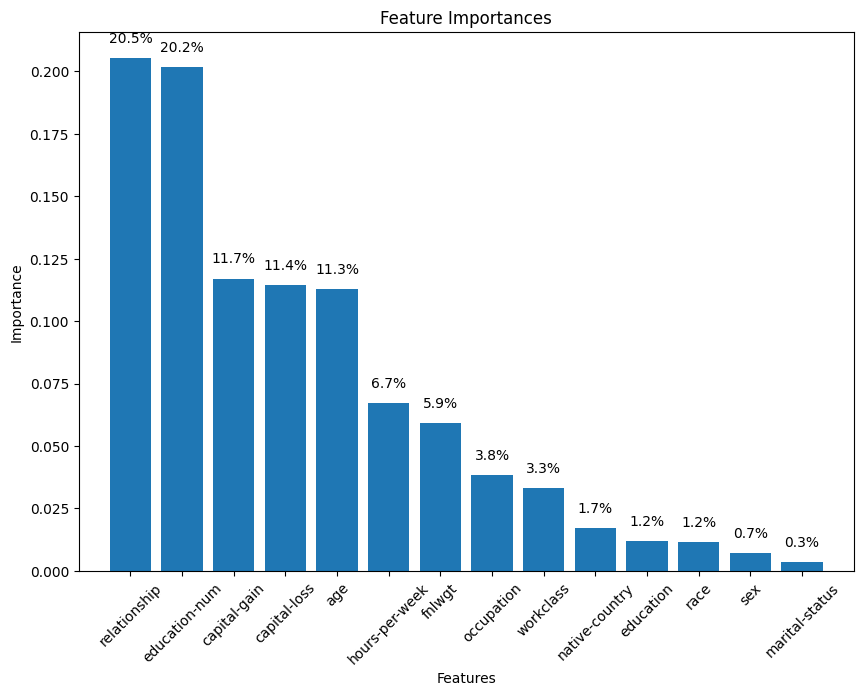

Accuracy: 0.86
Precision: 0.76
Recall: 0.57


In [332]:
dec_tree_clf, accuracy, precision, recall = train_decision_tree(X_clean, y_clean_string, 
                                                      criterion = 'gini', 
                                                      splitter = 'best', max_depth = 10,
                                                      min_samples_split = 20,
                                                      min_samples_leaf = 10)

I chose relatively low values at the start, and increased various parameters to see how they would affect the accuracy, precision, and recall values. I was able to reach a maximum accuracy of 86%. I noticed that, at a point after increasing the parameters, the accuracy values began to go down again, despite having risen when I increased them before. More testing would have to be done to select the optimal combination. I also found it interesting that relationship status was consistently the feature of most importance, despite the feature of second-most importance varying a lot as I changed the parameters.

# **Part 3: Random Forest and Ensembling Evaluation (40 Points)**

## For Parts 3 and 4, you may pick *your own dataset* or continue with the census data.

## Like above, you will want to reference the documentation as necessary:
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


## **Data**
## Use this space to load and call your data for Parts 3 and 4. You are welcome to use your final project data for these sections.

In [333]:
# N/A

## **Question 1 (10 points):**

## Write a function to take in a feature variable (X) and a target variable (y). Create a train test split for the variables.

## Finally, instantiate, fit, and predict using **both** a single Decision Tree and a Random Forest classifier. Print the accuracy, precision, and recall for both models.

## Call your function and describe your baseline results.


In [334]:
def dec_tree_rand_forest(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=467)

    dec_tree = DecisionTreeClassifier(random_state = 467)
    dec_tree.fit(X_train, y_train)
    dec_predic = dec_tree.predict(X_test)

    rf = RandomForestClassifier(random_state=467)
    rf.fit(X_train, y_train)
    rf_predic = rf.predict(X_test)

    print(f"Decision Tree Classifier:\nAccuracy: {accuracy_score(y_test, dec_predic):.2f}, Precision: {precision_score(y_test, dec_predic, average='macro'):.2f}, Recall: {recall_score(y_test, dec_predic, average='macro'):.2f}")
    print(f"Random Forest Classifier:\nAccuracy: {accuracy_score(y_test, rf_predic):.2f}, Precision: {precision_score(y_test, rf_predic, average='macro'):.2f}, Recall: {recall_score(y_test, rf_predic, average='macro'):.2f}")

In [335]:
dec_tree_rand_forest(X_clean, y_clean_string)

Decision Tree Classifier:
Accuracy: 0.81, Precision: 0.74, Recall: 0.74
Random Forest Classifier:
Accuracy: 0.86, Precision: 0.82, Recall: 0.78


These baseline results show that the accuracy, precision, and recall are all better in the Random Forest classifier than the decision tree.


## **Question 2 (30 points):**
## This question will ask you to tune Random Forest classifiers and preprocess your data in *any number of ways* to achieve the *best possible results you can*.

## Train one vanilla Decision Forest model and one vanilla Random Forest model and store their accuracies in variables so you can use them as baselines.

## Then, using functions or not, spend some time tuning at least 10 (or more) Random Forest models. Store your accuracies in a list or array and print your maximum accuracy.

# **Go crazy - feel free to implement sampling, dropping features, preprocessing, new parameters, whatever might boost your accuracy.**

# **The top 5 best accuracies in the class will get +15 on their individual lab grade!**

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean_string, test_size=0.3, random_state=777)

In [337]:
import warnings
warnings.filterwarnings('ignore')

In [338]:
def train_base_model(X_train, X_test, y_train, y_test):

    dec_tree = DecisionTreeClassifier(random_state = 777)
    dec_tree.fit(X_train, y_train)
    dec_acc = accuracy_score(y_test, dec_tree.predict(X_test))

    rf = RandomForestClassifier(random_state=777)
    rf.fit(X_train, y_train)
    rf_acc = accuracy_score(y_test, rf.predict(X_test))

    print(f"Decision Tree Accuracy: {(dec_acc) * 100:.2f}%")
    print(f"Random Forest Accuracy: {(rf_acc) * 100:.2f}%")

    return dec_acc, rf_acc

In [339]:
base_dt_acc, base_rf_acc = train_base_model(X_train, X_test, y_train, y_test)

Decision Tree Accuracy: 81.14%
Random Forest Accuracy: 85.44%


In [340]:
def tune_rand_forest(X_train, X_test, y_train, y_test):

    accuracies = []
    params = []
    n_est = [50, 100, 150, 200]
    max_depth = [None, 15, 30, 45]
    min_samples_split = [5, 10, 15]

    for n in n_est:
        for md in max_depth:
            for mss in min_samples_split:
                rf = RandomForestClassifier(n_estimators=n, max_depth=md, min_samples_split=mss, random_state=777)
                rf.fit(X_train, y_train)
                accuracy = accuracy_score(y_test, rf.predict(X_test))
                accuracies.append(accuracy)
                params.append((accuracy, n, md, mss))
    
    return accuracies, params

In [341]:
tuned_acc, params = tune_rand_forest(X_train, X_test, y_train, y_test)
print(f"Maximum tuned random forest accuracy: {max(tuned_acc)*100:.2f}%")

Maximum tuned random forest accuracy: 86.37%


# **Part 4: Ensemble Model Interpretation and Reflection (15 Points)**


## **Question 1 (5 points):**
## Create a plot that summarizes the results of your experiments and how they compare to the results of your baseline Decision Tree and Random Forest model.

## You may visualize your results in any type of plot you see fit. Color code your visual in some way so that models that did better than the baseline Random Forest are distinguished from models that did worse.

In [342]:
def visualize(base_dt_acc, base_rf_acc, accuracies):

    total_accuracies = [base_dt_acc, base_rf_acc] + accuracies
    labels = ['Base DT', 'Base RF'] + ['Tuned RF'] * len(accuracies)

    combined = list(zip(total_accuracies, labels))
    combined.sort(key=lambda x: x[0])

    sorted_acc, sorted_labels = zip(*combined)

    colors = ['red' if acc <= base_rf_acc else 'green' for acc in sorted_acc]

    plt.figure(figsize=(15,10))
    bars = plt.bar(range(len(sorted_acc)), sorted_acc, color=colors)
    plt.xlabel('Model Variants')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Decision Tree and Random Forest Models')
    plt.xticks(range(len(sorted_acc)), sorted_labels, rotation=90)

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.005, round(bar.get_height()*100), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

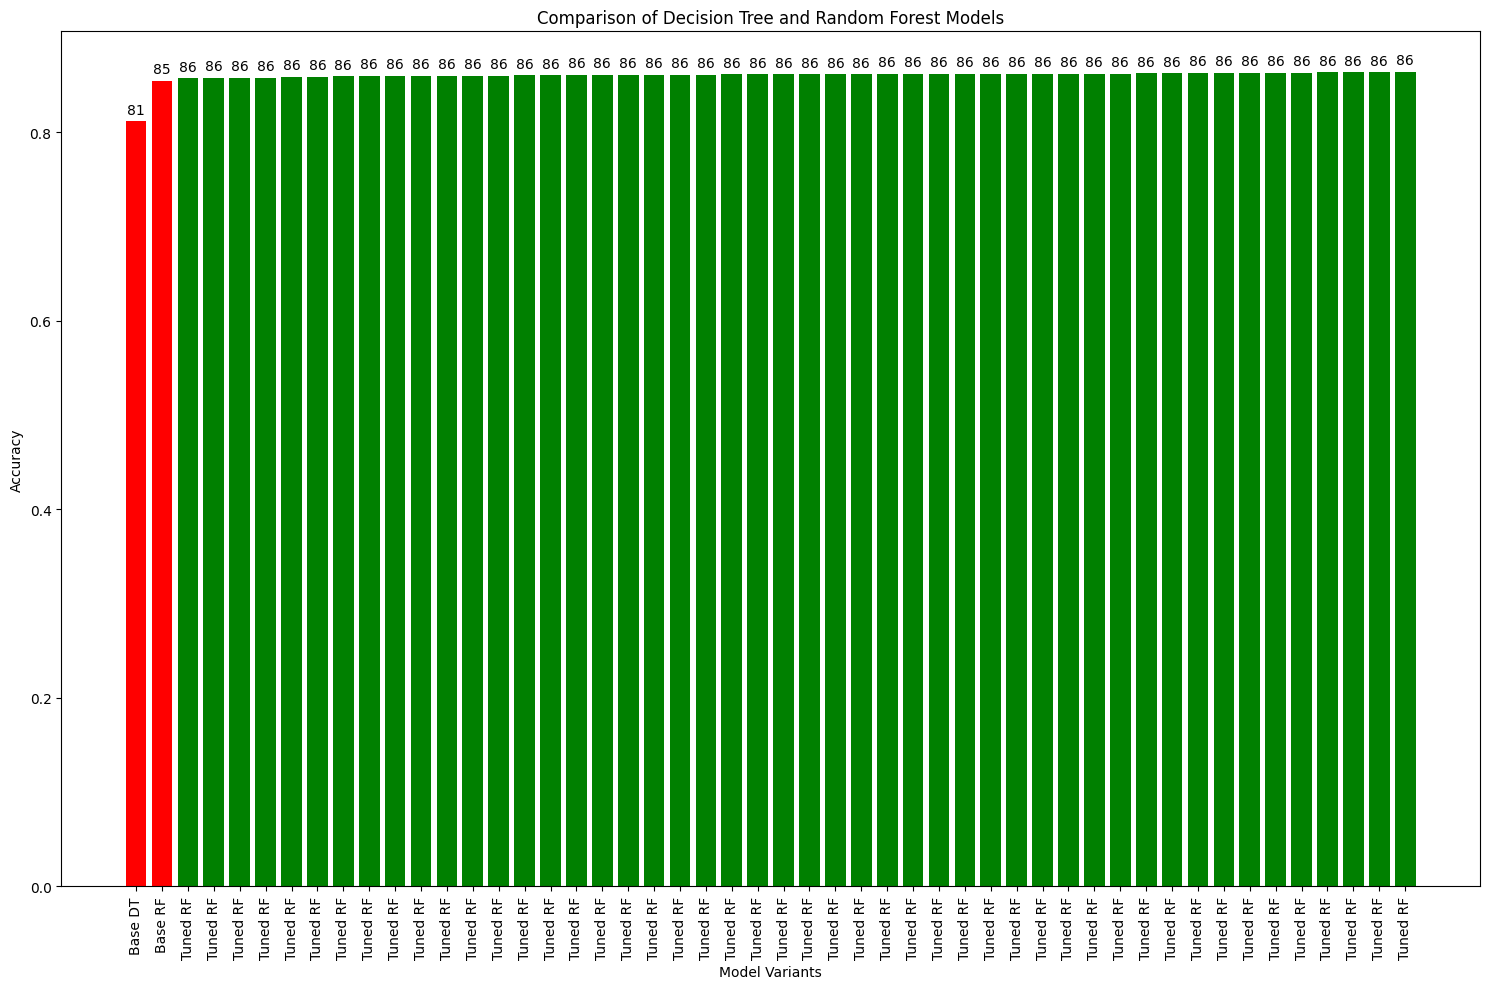

In [343]:
visualize(base_dt_acc, base_rf_acc, tuned_acc)

## **Question 2 (5 points):**
## Write 10 or more sentences on what parameters had the biggest effect or did not seem to effect your results. Did any parameter choices make your results worse than your vanilla model?

In [344]:
results_df = pd.DataFrame(params, columns=['accuracy', 'n_estimators', 'max_depth', 'min_samples_split'])
results_df

,accuracy,n_estimators,max_depth,min_samples_split
0,0.857777,50,NaN,5
1,0.860165,50,NaN,10
2,0.859210,50,NaN,15
3,0.861871,50,15.0,5
4,0.861257,50,15.0,10
5,0.861325,50,15.0,15
6,0.861667,50,30.0,5
7,0.859687,50,30.0,10
8,0.860984,50,30.0,15
9,0.857162,50,45.0,5


In [345]:
print(results_df.groupby('n_estimators')['accuracy'].mean())
print(results_df.groupby('max_depth')['accuracy'].mean())
print(results_df.groupby('min_samples_split')['accuracy'].mean())

best_result = results_df.loc[results_df['accuracy'].idxmax()]

print(f'\nBest result:\n{best_result}')

n_estimators
50     0.860159
100    0.860819
150    0.861399
200    0.861837
Name: accuracy, dtype: float64
max_depth
15.0    0.862082
30.0    0.861388
45.0    0.860324
Name: accuracy, dtype: float64
min_samples_split
5     0.860076
10    0.861347
15    0.861739
Name: accuracy, dtype: float64

Best result:
accuracy               0.863714
n_estimators         100.000000
max_depth             15.000000
min_samples_split      5.000000
Name: 15, dtype: float64


**The parameters I chose...** resulted in a maximum accuracy of 86.4% with n_estimators = 100, max_depth = 15, and min_samples_split = 5. After looking at the average accuracies for each parameter, it seems that max_depth had the biggest effect on performance overall. The highest mean accuracy came from max_depth = 15, but there wasn’t a super clear trend across the different depth values. In fact, the results fluctuated a bit, and it was hard to pinpoint a consistent pattern. That said, 15.0 seemed to work best in my case, and testing a wider range of depth values might help identify an even better option.

For n_estimators, I noticed a steady but small increase in accuracy as the number of trees increased. Going from 50 to 200 did improve results slightly, but the gains got smaller with each increase, which suggests that adding more trees gives diminishing returns after a certain point. Similarly, with min_samples_split, the changes in accuracy were pretty minimal, but the best performance came from the smallest value I tested (5). This might mean smaller splits help the model better fit the data, at least in this case.

None of the parameter combinations I tested performed worse than my vanilla model, so tuning definitely helped. I tried to keep the range of values somewhat limited so that the code could run efficiently on my laptop. Ideally, running a full grid search or using something like randomized search across a broader range would give even better results—but that would take a lot more time to run.

## **Question 3 (5 points):**
## Write 10 or more sentences reflecting on the tuning process.

## What kind of approach did you take? Was it random combinations or more structured? Did you change your approach after seeing your initial results?

## What kind of strategies in preprocessing and picking parameters (ie: brute forcing parameters, testing various values in a range) do you think would get some of the best scores in the class?

**My approach to tuning...** the random forest model was to pick the lowest reasonable values for each parameter and then increase them incrementally to test their impact. Specifically, I chose a range of values for n_estimators, max_depth, and min_samples_split, and ran a series of nested for-loops to try every possible combination. I wanted to keep the values within a manageable range so the function wouldn’t take too long to run, but still give me enough variation to see which combinations performed best. I didn’t change my approach much after running the first few tests because I felt like the ranges I picked were giving me decent results and didn’t require much adjustment. Given more time, I would have liked to go back to see if I could achive better numbers and see what time most optimal combination would be.

The structure of my approach was fairly systematic rather than random—I started with small values and increased them step-by-step. This helped me track how each parameter influenced the overall accuracy. I didn’t experiment with more complex techniques like grid search or randomized search, mostly because of time and computing limitations. That said, I think brute-forcing through a structured range of values, like I did, can be a good way to find decent hyperparameters without needing anything too fancy.

In terms of preprocessing, I didn’t make a lot of changes, but I can see how removing less important columns or dealing with missing values more intentionally could boost model performance. For example, getting rid of features that are either redundant (education, which was synonymous with education-num, and marital-status, which was synonymous with relationship) or carry very little importance (sex, race, and native country) might help the model generalize better. Looking at feature importance could guide this process even more. To get some of the best scores in the class, I think testing a wider range of values and cleaning the data more aggressively would help a lot.

### Honor Pledge

On my honor as a student, I have neither given nor received unauthorized aid on this assignment.